# Setup

In [ ]:
# This sets up the R environment, loads packages, custom functions, etc.
    bustalab = TRUE
    source("https://thebustalab.github.io/phylochemistry/phylochemistry.R")

# This reads in the manually evaluated data
    data <- read_csv("https://raw.githubusercontent.com/thebustalab/phylochemical_mapping/main/manually_inspected_literature.csv")
    data$compound_class[data$compound_class == "Isoquinoline alkaloids"] <- "Dopamine derived compounds"
    data <- data[!is.na(data$compound_name),]

# Build a tree from those species
    tree <- buildTree(
        scaffold_type = "newick",
        scaffold = "https://thebustalab.github.io/data/plant_phylogeny.newick",
        members = unique(data$species)
    )

# Collapse tree on families or Order
    angiosperms <- readMonolist("https://raw.githubusercontent.com/thebustalab/phylochemical_mapping/main/angiosperms.csv")
    angiosperms %>%
        filter(Genus_species %in% unique(data$species)) %>%
        select(Genus_species, Order) -> associations
    collapseTree(tree, associations) -> tree
    tree$edge.length <- rep(1, length(tree$edge.length))
    tree <- fortify(tree)

# Summarize compound occurrence data and prep it for heat map
    angiosperms %>%
        group_by(Order) %>%
        summarize(
            species_per_order = length(Genus_species)
        ) -> species_per_order

    data %>%
        group_by(compound_name, Order, compound_class) %>%
        summarize(
            n_reports_this_compound_per_order = as.numeric(length(unique(title))),
            n_species_this_compound_per_order = as.numeric(length(unique(species)))
        ) -> all

    data %>%
        filter(`T/F/UC` == "T") %>%
        group_by(compound_name, Order, compound_class) %>%
        summarize(
            n_reports_this_compound_per_order_T = as.numeric(length(unique(title))),
            n_species_this_compound_per_order_T = as.numeric(length(unique(species)))
        ) -> T

    data %>%
        filter(`T/F/UC` == "F") %>%
        group_by(compound_name, Order, compound_class) %>%
        summarize(
            n_reports_this_compound_per_order_F = as.numeric(length(unique(title))),
            n_species_this_compound_per_order_F = as.numeric(length(unique(species)))
        ) -> F

    left_join(left_join(all, T), F) %>%
    ungroup() %>%
        group_by(compound_name) %>%
        mutate(
            tot_reports_this_compound = as.numeric(sum(n_reports_this_compound_per_order)),
            tot_species_this_compound = as.numeric(sum(n_species_this_compound_per_order)),
            tot_reports_this_compound_T = as.numeric(sum(n_reports_this_compound_per_order_T)),
            tot_species_this_compound_T = as.numeric(sum(n_species_this_compound_per_order_T)),
            tot_reports_this_compound_F = as.numeric(sum(n_reports_this_compound_per_order_F)),
            tot_species_this_compound_F = as.numeric(sum(n_species_this_compound_per_order_F))
        ) -> heat_map_data
    heat_map_data$n_species_in_this_order <- species_per_order$species_per_order[match(heat_map_data$Order, species_per_order$Order)]
    heat_map_data$y <- tree$y[match(heat_map_data$Order, tree$label)]
    heat_map_data$Order <- factor(heat_map_data$Order, levels = filter(tree, isTip == TRUE)$label[filter(tree, isTip == TRUE)$y])
    heat_map_data$compound_class[is.na(heat_map_data$compound_class)] <- ""


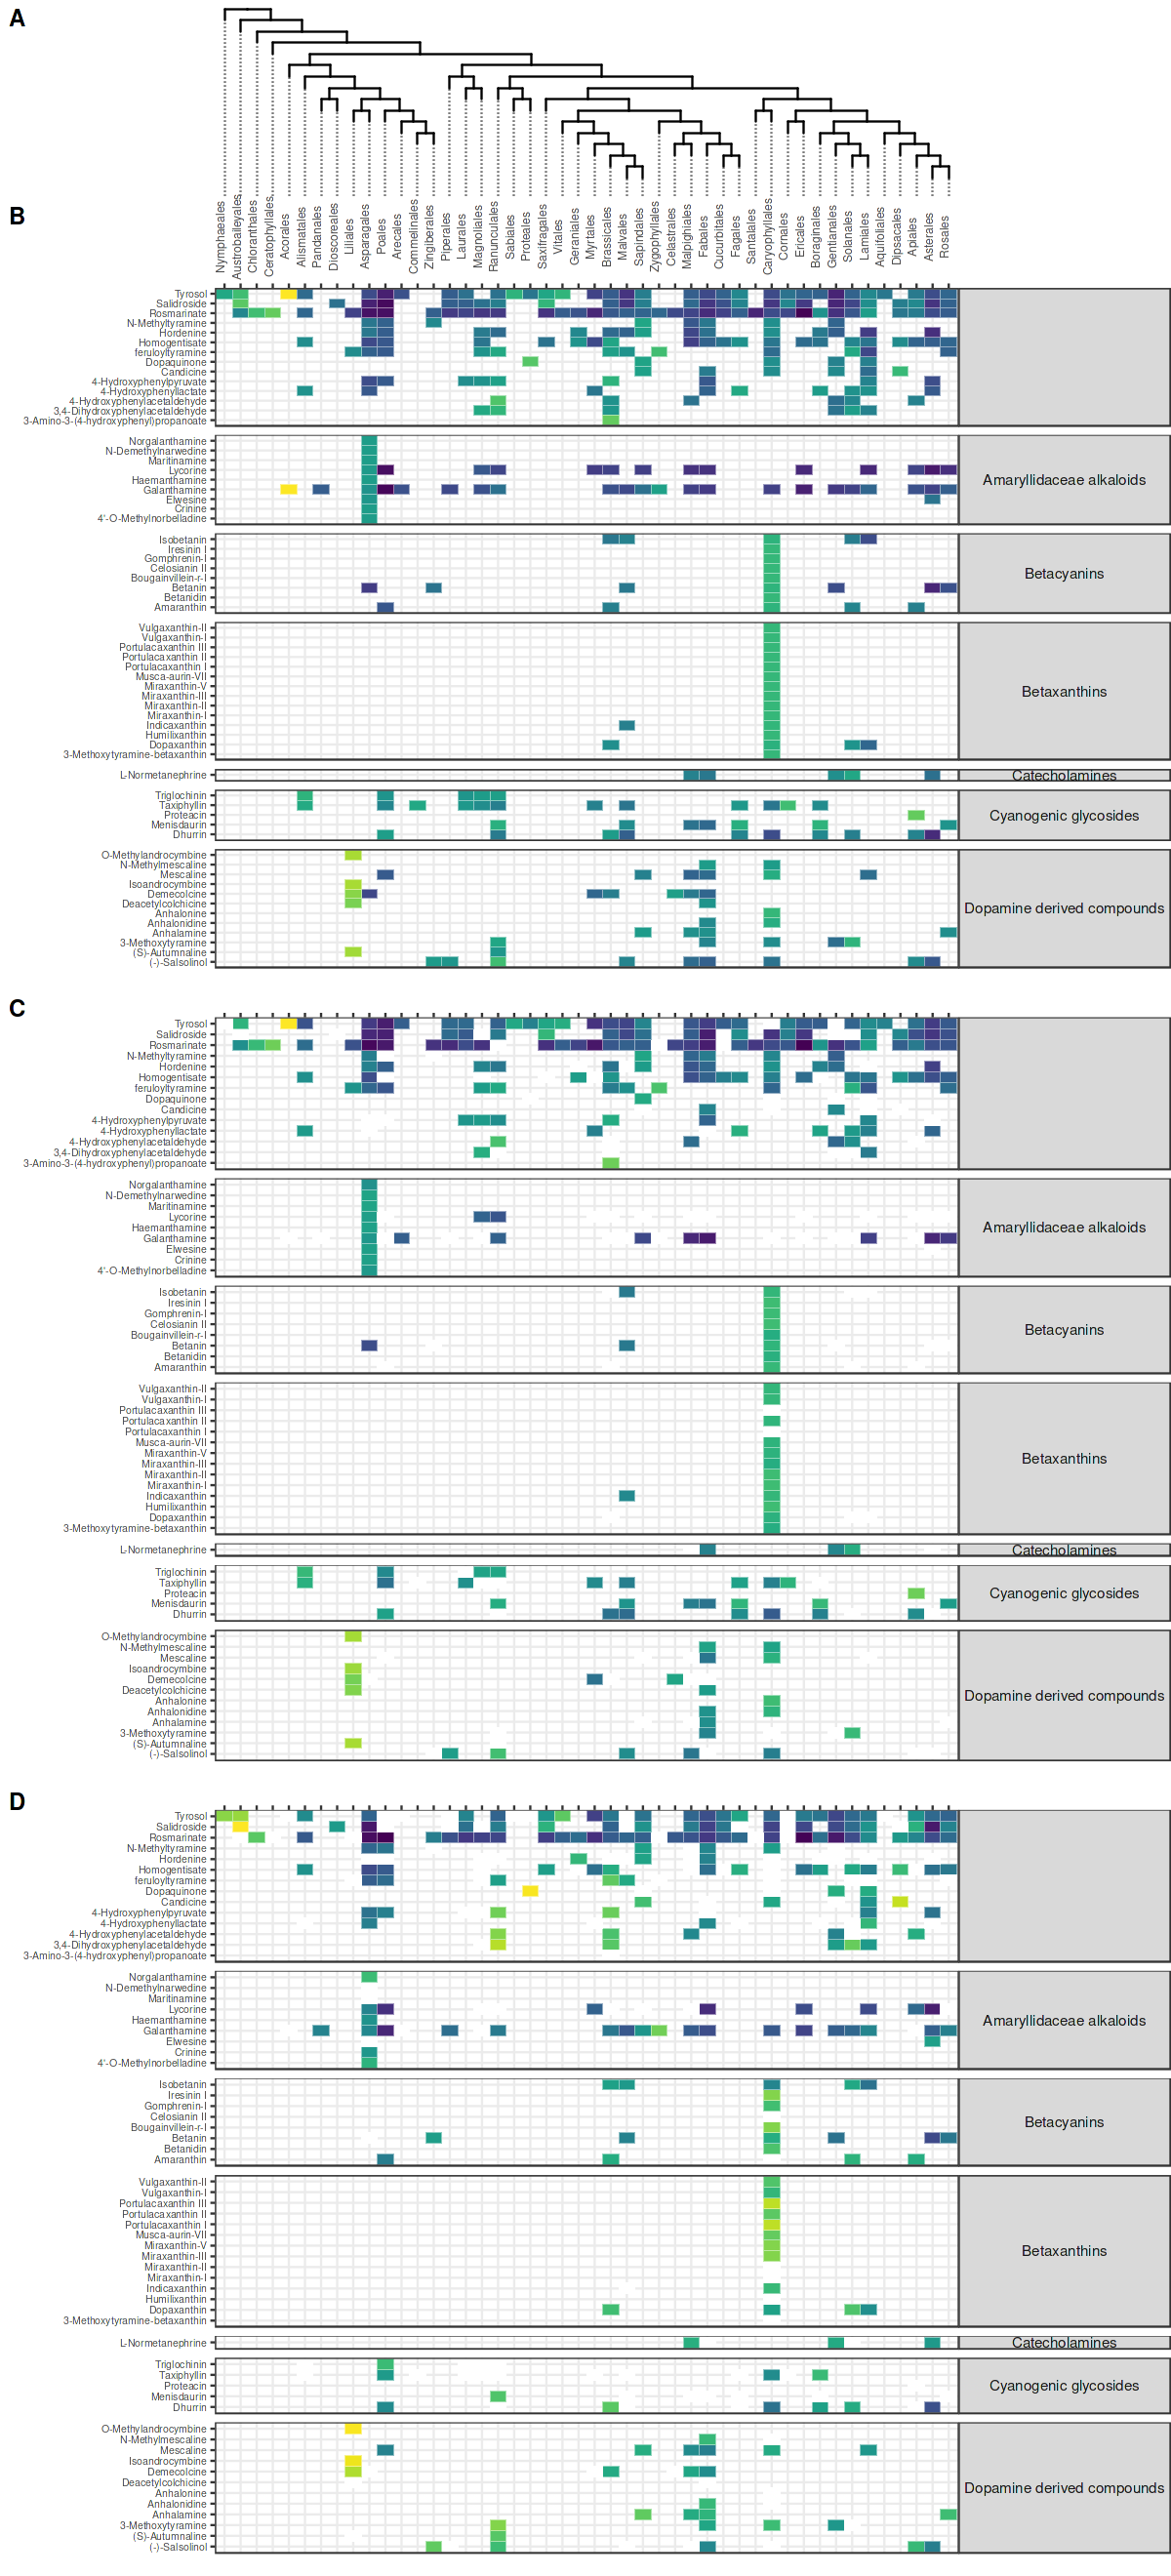

In [114]:
## Tree: Note: geom_label does not support rotation
    tree_plot <- ggtree(tree) +
        geom_tiplab(
            align = TRUE, hjust = 0, offset = -14, geom = "text",
            angle = 90, size = 3
        ) +
        theme_classic() + 
        theme_void() +
        coord_flip() + scale_x_reverse(limits = c(16,0))

# Heat maps
    heatmap1 <- ggplot(
            heat_map_data,
            aes(
                y = compound_name, x = reorder(Order, y),
                # fill = n_reports_this_compound_per_order
                # fill = log(n_reports_this_compound_per_order)
                # fill = log(n_reports_this_compound_per_order/n_species_in_this_order)
                # fill = log(n_reports_this_compound_per_order/tot_reports_this_compound)
                # fill = log(n_reports_this_compound_per_order/tot_species_this_compound)
                fill = log(n_reports_this_compound_per_order/tot_reports_this_compound/n_species_in_this_order)
            )
        ) +
        geom_tile(color = "white") +
        theme_bw() +
        # scale_fill_gradient(low = "#d9d9d9", high = "#000000", na.value = "white", name = "", guide = "none") +
        scale_fill_viridis(guide = "none", na.value = "white") +
        scale_y_discrete(name = "", drop = FALSE) +
        scale_x_discrete(name = "", drop = FALSE, position = "top") +
        facet_grid(compound_class~., space = "free_y", scale = "free_y") +
        theme(
            axis.text.x = element_text(vjust = 0, angle = 90, hjust = 0.5, size = 7),
            # axis.text.x = element_blank(),
            axis.text.y = element_text(angle = 0, size = 6),
            plot.margin = unit(c(-0.5,0,0.5,0), "cm"),
            strip.text.y = element_text(angle = 0)
        )

    heatmap2 <- ggplot(
            heat_map_data,
            aes(
                y = compound_name, x = reorder(Order, y),
                # fill = n_reports_this_compound_per_order_T
                # fill = log(n_reports_this_compound_per_order_T)
                # fill = log(n_reports_this_compound_per_order_T/n_species_in_this_order)
                # fill = log(n_reports_this_compound_per_order_T/tot_reports_this_compound)
                # fill = log(n_reports_this_compound_per_order_T/tot_species_this_compound)
                fill = log(n_reports_this_compound_per_order_T/tot_reports_this_compound/n_species_in_this_order)
            )
        ) +
        geom_tile(color = "white") +
        theme_bw() +
        # scale_fill_gradient(low = "#d9d9d9", high = "#000000", na.value = "white", name = "", guide = "none") +
        scale_fill_viridis(guide = "none", na.value = "white") +
        scale_y_discrete(name = "", drop = FALSE) +
        scale_x_discrete(name = "", drop = FALSE, position = "top") +
        facet_grid(compound_class~., space = "free_y", scale = "free_y") +
        theme(
            # axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5),
            axis.text.x = element_blank(),
            axis.text.y = element_text(angle = 0, size = 6),
            plot.margin = unit(c(0,0,0.5,0), "cm"),
            strip.text.y = element_text(angle = 0)
        )

    heatmap3 <- ggplot(
            heat_map_data,
            aes(
                y = compound_name, x = reorder(Order, y),
                # fill = n_reports_this_compound_per_order_F
                # fill = log(n_reports_this_compound_per_order_F)
                # fill = log(n_reports_this_compound_per_order_F/n_species_in_this_order)
                # fill = log(n_reports_this_compound_per_order_F/tot_reports_this_compound)
                # fill = log(n_reports_this_compound_per_order_F/tot_species_this_compound)
                fill = log(n_reports_this_compound_per_order_F/tot_reports_this_compound/n_species_in_this_order)
            )
        ) +
        geom_tile(color = "white") +
        theme_bw() +
        # scale_fill_gradient(low = "#d9d9d9", high = "#000000", na.value = "white", name = "", guide = "none") +
        # scale_fill_viridis(guide = "none", na.value = "white") +
        scale_fill_viridis(na.value = "white", guide = "none") +
        scale_y_discrete(name = "", drop = FALSE) +
        scale_x_discrete(name = "", drop = FALSE, position = "top") +
        facet_grid(compound_class~., space = "free_y", scale = "free_y") +
        theme(
            # axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5),
            axis.text.x = element_blank(),
            axis.text.y = element_text(angle = 0, size = 6),
            plot.margin = unit(c(0,0,0.5,0), "cm"),
            strip.text.y = element_text(angle = 0)
        )

options(repr.plot.width = 10, repr.plot.height = 22)
plot_grid(
    tree_plot, heatmap1, heatmap2, heatmap3, align = "v", axis = "lr", rel_heights = c(0.5,2,2,2),
    ncol = 1, labels = c("A", "B", "C", "D")
)

# Language Model Evaluation

## Example code for issuing queries

In [ ]:
## This is currently configured to do abstract versus full text with gpt-3.5-turbo-0613.
## Full texts need to be read in and added to the 'data' dataframe.
## We do not include full texts in this repository for copyright reasons.
## The same style of code was used for assessing the various models.

n_articles <- 250
n_iterations <- 3
sampled_indicies <- sample(1:nrow(data), n_articles, replace = FALSE)

all_iterations_results <- list()
pb <- txtProgressBar(min = 0, max = n_articles, style = 3)
    for(j in 1:n_iterations){ #j=1
            results <- list()
            k = 1
            for ( i in sampled_indicies ) { # i = sampled_indicies[1]
                
                cat("Processing iteration:", j, " i:", i, "\n")
                ## Formulates the query
                    query <- paste(
                        "Here is the title: ",
                        data$title[i],
                        "Here is the abstract: ",
                        data$abstract[i],
                        " classify your response as \"yes\" or \"no\": was ",
                        data$compound_name[i],
                        " found in ",
                        data$species[i],
                        "? Do not include a period in your response. Respond only with yes or no and no other explanation or text."
                    )

                ## Sends the request to GPT and compiles the answers
                    output <- completionGPT(
                        system_prompt = "You are an expert in scientific literature and can easily and accurately parse text for scientific literature tasks.",
                        query = query,
                        model = "gpt-3.5-turbo-0613",
                        temperature = 0, # 0 -> 2
                        openai_api_key = openai_api_key
                    )
                    results[[i]] <- data.frame(
                        model = output$model,
                        gpt_says = gsub("\n", "", output$response),
                        compound = data$compound_name[i],
                        species = data$species[i],
                        manual_inspection_says = data$`T/F/UC`[i],
                        index = as.character(i)
                    )
                setTxtProgressBar(pb, k)
                k <- k + 1
                Sys.sleep(1)
            }

            abstract_results <- do.call(rbind, results)

            results <- list()
            for ( i in sampled_indicies ) {

                ## Formulates the query
                    query <- paste(
                        "Here is the title: ",
                        data$title[i],
                        "Here is the full text: ",
                        data$full_text[i],
                        " classify your response as \"yes\" or \"no\": was ",
                        data$compound_name[i],
                        " found in ",
                        data$species[i],
                        "? Do not include a period in your response. Respond only with yes or no and no other explanation or text."
                    )

                ## Sends the request to GPT and compiles the answers
                    output <- completionGPT(
                        system_prompt = "You are an expert in scientific literature and can easily and accurately parse text for scientific literature tasks.",
                        query = query,
                        model = "gpt-3.5-turbo-16k-0613",
                        temperature = 0, # 0 -> 2
                        openai_api_key = openai_api_key
                    )
                    results[[i]] <- data.frame(
                        model = output$model,
                        gpt_says = gsub("\n", "", output$response),
                        compound = data$compound_name[i],
                        species = data$species[i],
                        manual_inspection_says = data$`T/F/UC`[i],
                        index = as.character(i)
                    )

                Sys.sleep(1)
            }

        full_text_results <- do.call(rbind, results)

        one_iterations_results <- rbind(
            cbind(abstract_results, data.frame(text_type = "abstract")),
            cbind(full_text_results, data.frame(text_type = "full_text"))
        )
        
        one_iterations_results$iteration <- j
        all_iterations_results[[j]] <- one_iterations_results
    }

all_iterations_results <- do.call(rbind, all_iterations_results)


## Evaluating OpenAI models

In [14]:
## This is all the model comparison data
read_csv("https://raw.githubusercontent.com/thebustalab/phylochemical_mapping/main/llm_model_evaluation.csv", show_col_types = FALSE) %>%
    group_by(status, category, iteration, model) %>%
    summarize(count = n()) %>%
    mutate(model = case_when(
        model == "text-davinci-003" ~ "davinci-003",
        model == "text-curie-001" ~ "curie-001",
        model == "text-babbage-001" ~ "babbage-001",
        model == "gpt-4-0613" ~ "gpt-4-0613",
        model == "gpt-3.5-turbo-0613" ~ "gpt-3.5-turbo-0613"
    )) -> model_comparison_data
model_comparison_data$judgement <- tolower(paste0(model_comparison_data$status, "_", model_comparison_data$category))
model_comparison_data$model <- factor(model_comparison_data$model, levels = rev(c("babbage-001","curie-001","davinci-003","gpt-3.5-turbo-0613","gpt-4-0613")))
model_comparison_data$model <-  gsub("-|\\.", "_", model_comparison_data$model)

model_comparison_data %>% ungroup() %>%
    select(model, count, judgement) %>%
    # group_by(model, judgement) %>% shapiroTest(count)
    # group_by(judgement) %>% leveneTest(count ~ model)
    # group_by(judgement) %>% anovaTest(count ~ model)
    group_by(judgement) %>% tukey_hsd(count ~ model) -> tukey_results

rbind(
    cbind(
        data.frame(judgement = "true_positive"),
        tukey_results %>% filter(judgement == "true_positive") %>% pGroups()
    ),
    cbind(
        data.frame(judgement = "false_negative"),
        tukey_results %>% filter(judgement == "false_negative") %>% pGroups()
    ),
    cbind(
        data.frame(judgement = "false_positive"),
        tukey_results %>% filter(judgement == "false_positive") %>% pGroups()
    ),
    cbind(
        data.frame(judgement = "true_negative"),
        tukey_results %>% filter(judgement == "true_negative") %>% pGroups()
    )
) -> model_comparison_data_tukey_groupings
rownames(model_comparison_data_tukey_groupings) <- NULL

model_comparison_data %>%
    group_by(model, iteration) %>%
    mutate(
        count_percent = count/sum(count)*100,
        sum_count = sum(count)
    ) %>% ungroup() %>%
    group_by(model, judgement) %>%
    summarize(
        mean = mean(count),
        sd = sd(count),
        mean_percent = mean(count_percent),
        sd_percent = sd(count_percent)
    ) -> model_comparison_data_summarized

model_comparison_data_summarized %>%
    mutate(
        status = toupper(gsub("_.*$", "", judgement)),
        category = gsub(".*_", "", judgement)
    ) -> model_comparison_data_summarized

model_comparison_data_summarized_w_groups <- left_join(model_comparison_data_tukey_groupings, model_comparison_data_summarized, by = c("judgement", "treatment" = "model"))
model_comparison_data_summarized_w_groups <- dplyr::rename(model_comparison_data_summarized_w_groups, model = treatment)

## Evaluating effects of full texts

In [16]:
## Read in data
    read_csv("https://raw.githubusercontent.com/thebustalab/phylochemical_mapping/main/llm_fulltext_evaluation.csv", show_col_types = FALSE) %>%
        group_by(status, category, model, iteration, text_type) %>%
        summarize(count = n()) %>%
        mutate(model = case_when(
            model == "gpt-3.5-turbo-0613" ~ "gpt-3.5-turbo-0613",
            model == "gpt-3.5-turbo-16k-0613" ~ "gpt-3.5-turbo-16k-0613"
        )) -> full_text_effect_data
    full_text_effect_data$model <-  gsub("-|\\.", "_", full_text_effect_data$model)
    full_text_effect_data$judgement <- tolower(paste0(full_text_effect_data$status, "_", full_text_effect_data$category))

    full_text_effect_data %>%
        group_by(status, category, text_type) %>%
        summarize(mean = mean(count), sd = sd(count)) -> full_text_effect_data_summarized

full_text_effect_data %>% ungroup() %>%
    select(text_type, judgement, iteration, model, count) %>%
    # group_by(text_type, model, judgement, iteration) %>% shapiroTest(variable = "count") -> shapiro_results
    # group_by(model, text_type, judgement, iteration) %>% summarize(count = n()) %>% ungroup() %>% leveneTest(count ~ model) -> levene_results
    # group_by(judgement) %>% anovaTest(count ~ model)
    group_by(judgement) %>% tukey_hsd(count ~ model) -> tukey_results

rbind(
    cbind(
        data.frame(judgement = "true_positive"),
        tukey_results %>% filter(judgement == "true_positive") %>% pGroups()
    ),
    cbind(
        data.frame(judgement = "false_negative"),
        tukey_results %>% filter(judgement == "false_negative") %>% pGroups()
    ),
    cbind(
        data.frame(judgement = "false_positive"),
        tukey_results %>% filter(judgement == "false_positive") %>% pGroups()
    ),
    cbind(
        data.frame(judgement = "true_negative"),
        tukey_results %>% filter(judgement == "true_negative") %>% pGroups()
    )
) -> full_text_effect_data_tukey_groupings
rownames(full_text_effect_data_tukey_groupings) <- NULL

full_text_effect_data %>%
    group_by(model, iteration, text_type) %>%
    mutate(
        count_percent = count/sum(count)*100,
        sum_count = sum(count)
    ) %>% ungroup() %>%
    group_by(model, judgement, text_type) %>%
    summarize(
        mean = mean(count),
        sd = sd(count),
        mean_percent = mean(count_percent),
        sd_percent = sd(count_percent)
    ) -> full_text_effect_data_summarized

full_text_effect_data_summarized %>%
    mutate(
        status = toupper(gsub("_.*$", "", judgement)),
        category = gsub(".*_", "", judgement)
    ) -> full_text_effect_data_summarized

full_text_effect_data_summarized_w_groups <- left_join(full_text_effect_data_tukey_groupings, full_text_effect_data_summarized, by = c("judgement", "treatment" = "model"))
full_text_effect_data_summarized_w_groups <- dplyr::rename(full_text_effect_data_summarized_w_groups, model = treatment)

## Plot LLM results

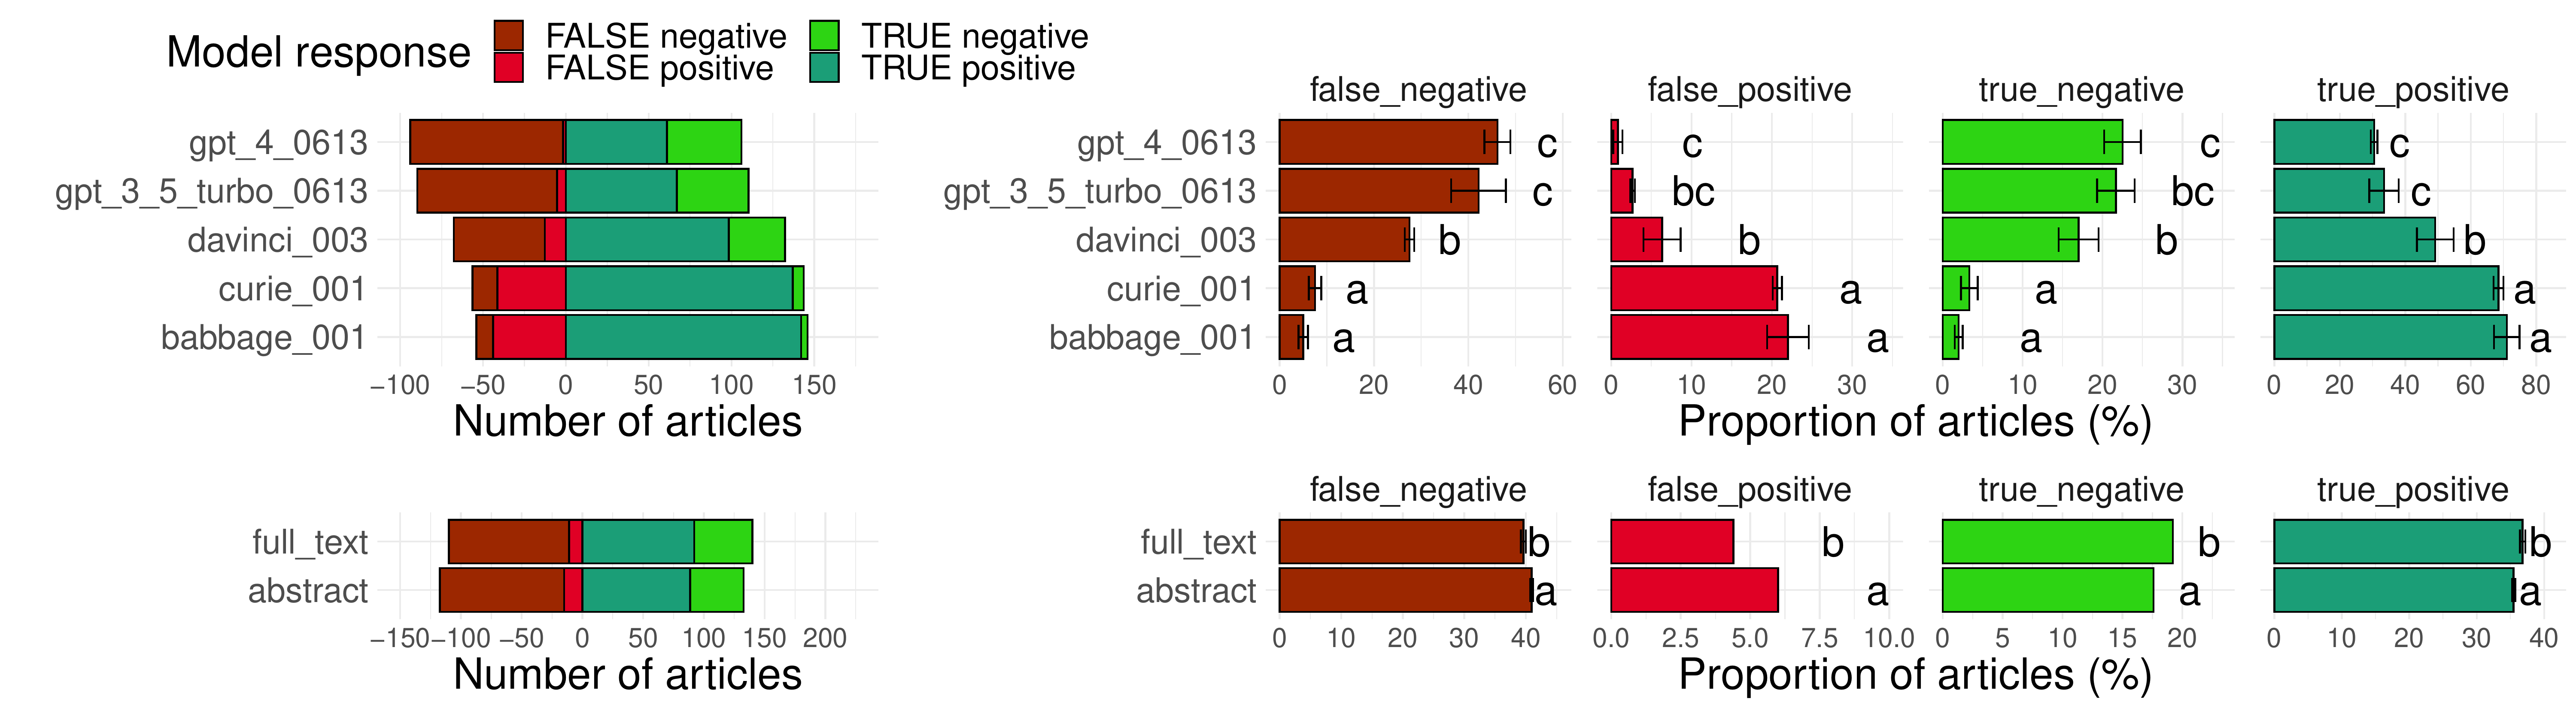

In [17]:
## Plotting model comparison data
    ggplot() +
        geom_bar(
            data = filter(model_comparison_data_summarized_w_groups, status == FALSE),
            aes(y = model, x = -mean, fill = paste(status,category)),
            stat = "identity", position = "stack", color = "black"
        ) +
        geom_bar(
            data = filter(model_comparison_data_summarized_w_groups, status == TRUE),
            aes(y = model, x = mean, fill = paste(status,category)),
            stat = "identity", position = "stack", color = "black"
        ) +
        scale_fill_manual(
            values = c("#9c2700", "#e00025", "#2dd413", "#1B9E77"),
            name = "Model response"
        ) +
        scale_x_continuous(breaks = seq(-200,300,50), limits = c(-100,175), name = "Number of articles") +
        scale_y_discrete(name = "") +
        theme_minimal() +
        guides(fill = guide_legend(nrow = 2)) +
        theme(
            text = element_text(size = 24),
            axis.text.x = element_text(size = 15),
            legend.position = "top"
        ) -> TA_overall

    model_comparison_data_summarized_w_groups %>%
        ggplot() +
            geom_col(
                aes(x = mean_percent, y = model, fill = judgement), color = "black"
            ) +
            geom_errorbar(
                aes(x = mean_percent, xmin = mean_percent-sd_percent, xmax = mean_percent+sd_percent, y = model), width = 0.5
            ) +
            geom_text(
                aes(x = (mean_percent+sd_percent)+10, y = model, label = group),
                size = 8, hjust = 1, vjust = 0.5
            ) +
            facet_grid(~judgement, scales = "free") +
            theme_minimal() +
            scale_x_continuous(name = "Proportion of articles (%)") +
            scale_y_discrete(name = "") +
            scale_fill_manual(
                values = c("#9c2700", "#e00025", "#2dd413", "#1B9E77"),
                name = "Model response", guide = "none"
            ) +
            theme(
                text = element_text(size = 24),
                axis.text.x = element_text(size = 15),
                panel.spacing = unit(1, "lines"),
                legend.position = "top"
            ) -> TA_error

## Plotting abstract v full text comparison data
    ggplot() +
        geom_bar(
            # data = filter(processed_data, category == "negative"),
            data = filter(full_text_effect_data_summarized_w_groups, status == FALSE),
            aes(y = text_type, x = -mean, fill = paste(status,category)),
            stat = "identity", position = "stack", color = "black"
        ) +
        geom_bar(
            # data = filter(processed_data, category == "positive"),
            data = filter(full_text_effect_data_summarized_w_groups, status == TRUE),
            aes(y = text_type, x = mean, fill = paste(status,category)),
            stat = "identity", position = "stack", color = "black"
        ) +
        scale_fill_manual(
            values = c("#9c2700", "#e00025", "#2dd413", "#1B9E77"),
            name = "Model response", guide = "none"
        ) +
        scale_x_continuous(breaks = seq(-200,300,50), limits = c(-150,225), name = "Number of articles") +
        scale_y_discrete(name = "") +
        theme_minimal() +
        # guides(fill = guide_legend(nrow = 2)) +
        theme(
            text = element_text(size = 24),
            axis.text.x = element_text(size = 15),
            legend.position = "top"
        ) -> FT_overall

    full_text_effect_data_summarized_w_groups %>%
        mutate(status_category = paste(status, category)) %>%
        ggplot() +
            geom_col(
                aes(x = mean_percent, y = text_type, fill = status_category), color = "black"
            ) +
            geom_errorbar(
                aes(x = mean_percent, xmin = mean_percent-sd_percent, xmax = mean_percent+sd_percent, y = text_type),
                width = 0.5
            ) +
            geom_text(
                aes(x = (mean_percent+sd_percent)+4, y = text_type, label = group),
                size = 8, hjust = 1, vjust = 0.5
            ) +
            facet_grid(~judgement, scales = "free") +
            theme_minimal() +
            scale_x_continuous(name = "Proportion of articles (%)") +
            scale_y_discrete(name = "") +
            scale_fill_manual(
                values = c("#9c2700", "#e00025", "#2dd413", "#1B9E77"),
                name = "Model response", guide = "none"
            ) +
            theme(
                text = element_text(size = 24),
                axis.text.x = element_text(size = 15),
                legend.position = "top"
            ) -> FT_error

## PLOT ZEM
    overall <- cowplot::align_plots(TA_overall, FT_overall, align = "v")
    error <- cowplot::align_plots(TA_error, FT_error, align = "v")

    pdf(file = "/project_data/shared/text_mining/figures/results.pdf", width = 20, height = 5.5)
    plot_grid(
        plot_grid(overall[[1]], error[[1]], align = "h", axis = "tb", rel_widths = c(1,1.9)),
        plot_grid(overall[[2]], error[[2]], align = "h", axis = "tb", rel_widths = c(1,1.9)),
        # labels = c("A", "B"),
        label_size = 24,
        ncol = 1, rel_heights = c(1.8,1.0)
    )
    invisible(dev.off())
    print(magick::image_read_pdf("/project_data/shared/text_mining/figures/results.pdf"), info=F)

# Articles missed by text mining

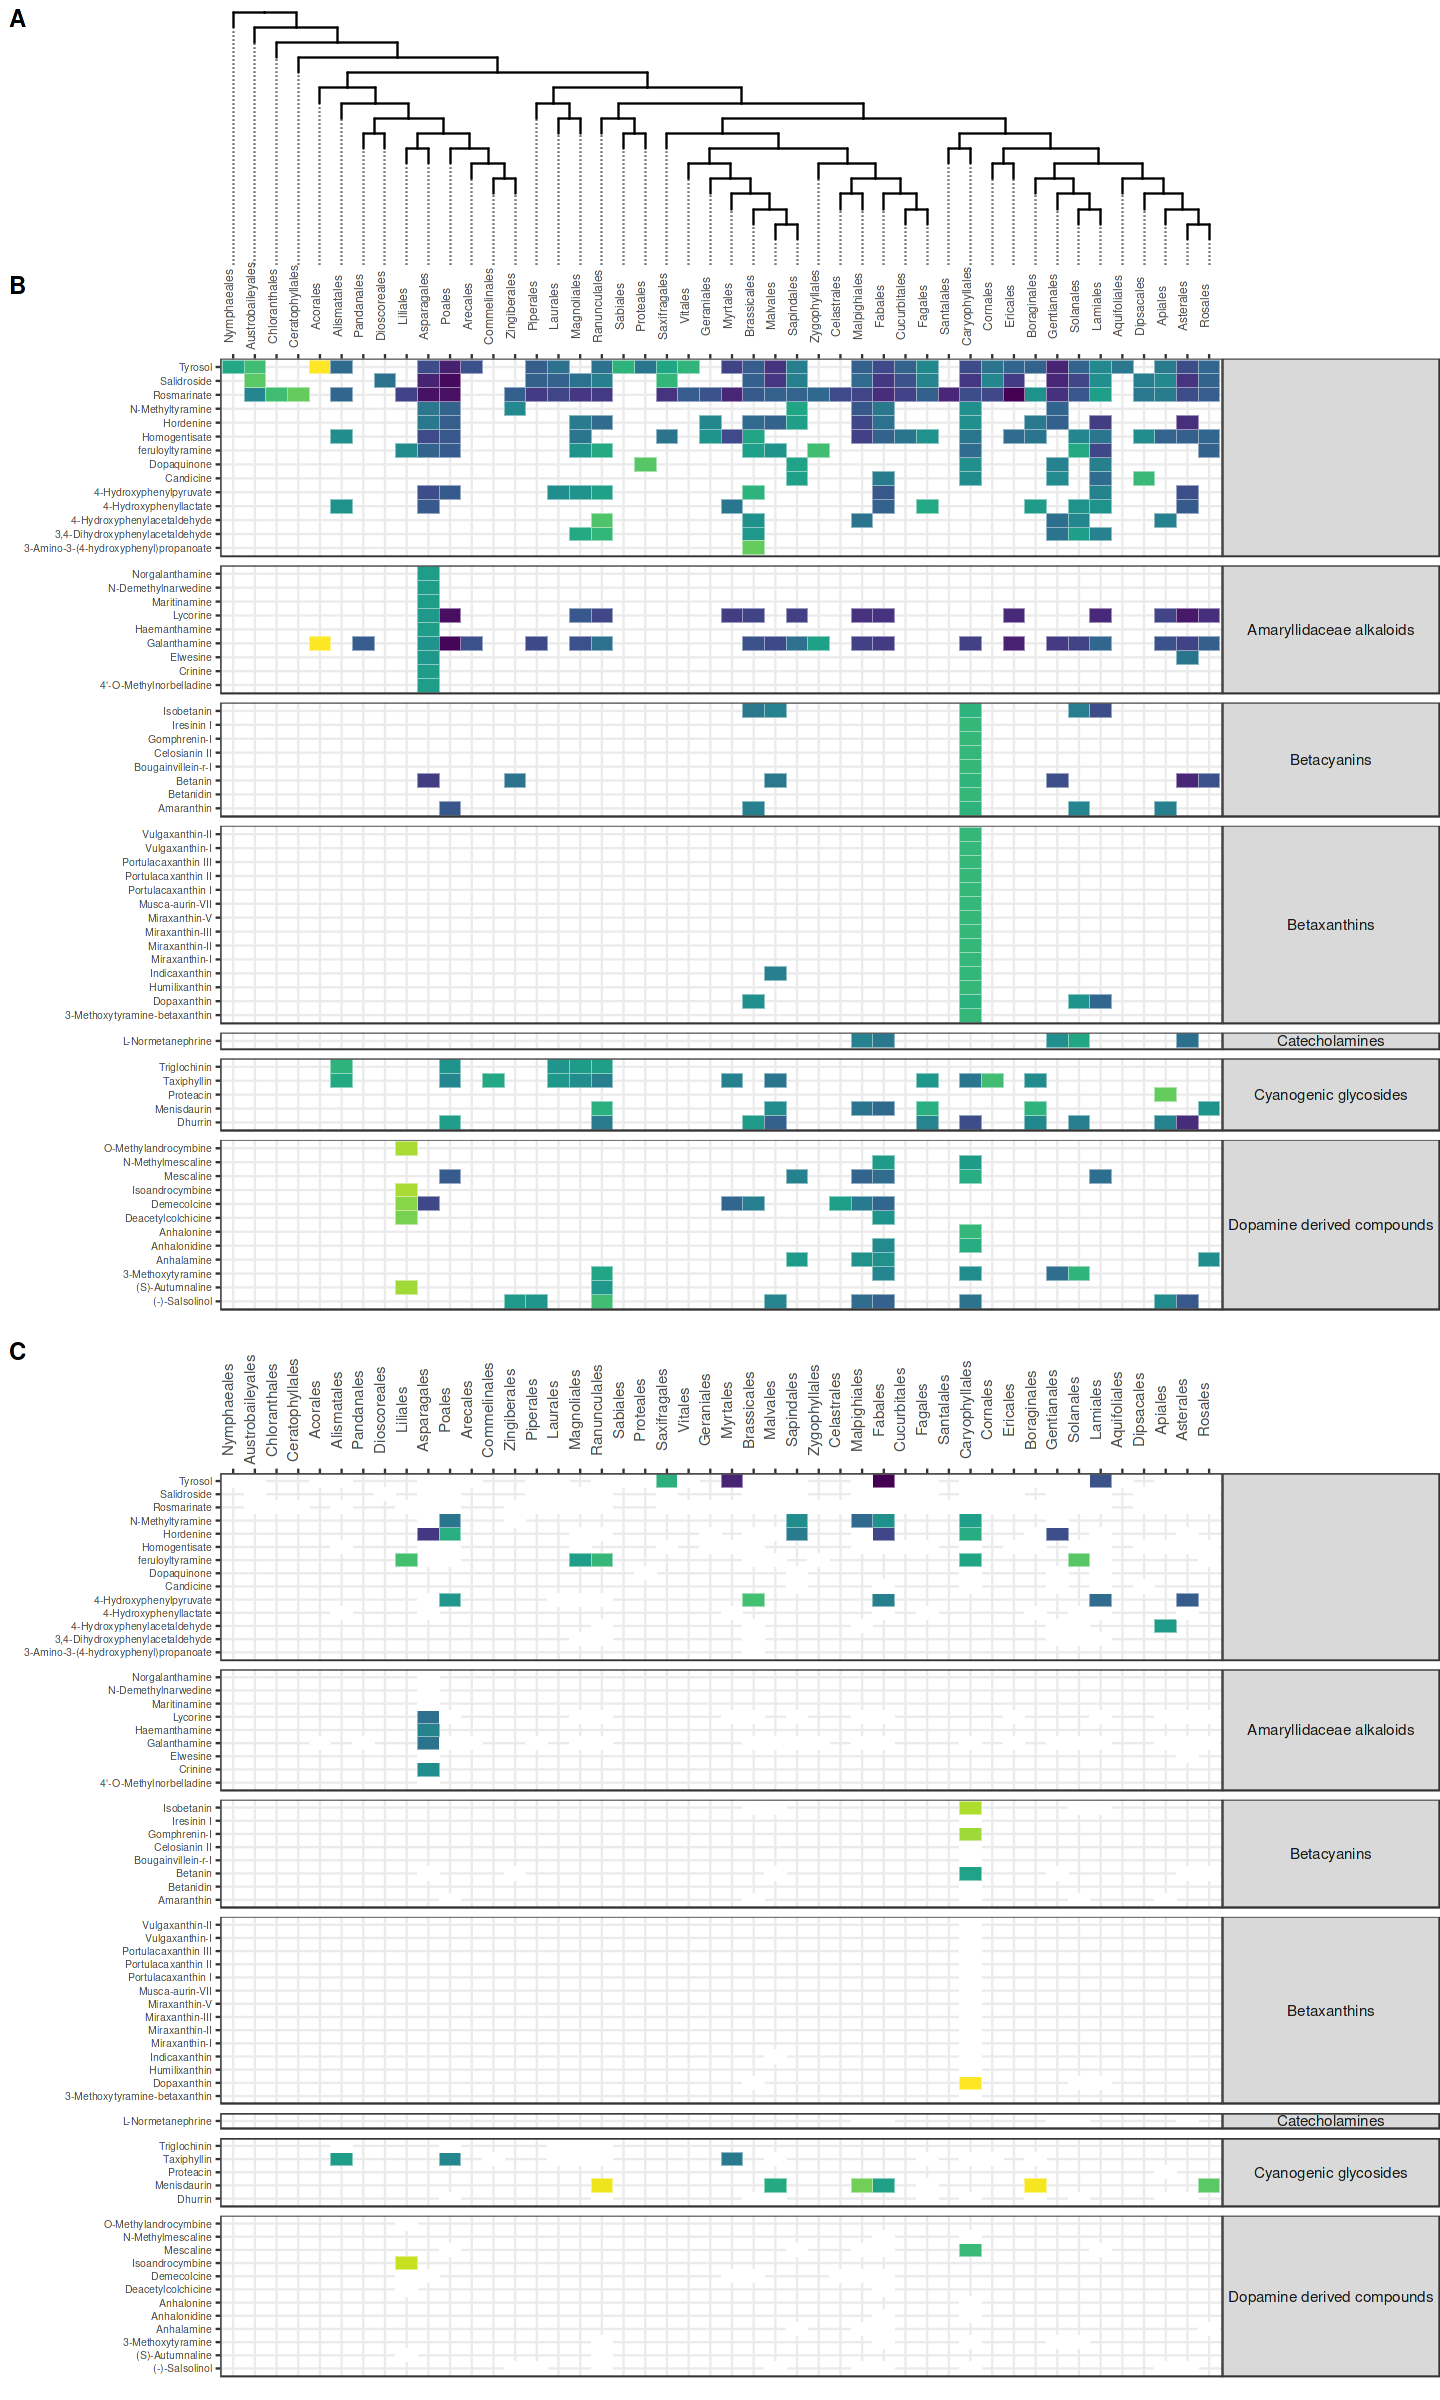

In [142]:
# Read in data, make it into a compatible dataframe
    readMonolist("https://raw.githubusercontent.com/thebustalab/phylochemical_mapping/main/associations_missed_by_text_mining.csv") %>%
    group_by(compound_name, Order) %>%
        summarize(count = n()) -> data_missed

    heat_map_data %>%
        select(
            compound_name, Order, compound_class, tot_reports_this_compound,
            n_species_in_this_order, y, n_reports_this_compound_per_order_T
        ) -> data_missed_heat_map_data

    data_missed_heat_map_data$n_reports_this_compound_per_order_T <- left_join(data_missed_heat_map_data, data_missed, by = c("compound_name", "Order"))$count

    order_levels <- heat_map_data %>% ungroup() %>% arrange(y) %>% select(Order) %>% unique() %>% unlist()
    data_missed_heat_map_data$Order <- factor(data_missed_heat_map_data$Order, levels = order_levels)

# Plot

    heatmap4 <- ggplot(
        data_missed_heat_map_data,
        aes(
            y = compound_name, x = reorder(Order, y),
            fill = log(n_reports_this_compound_per_order_T/tot_reports_this_compound/n_species_in_this_order)
        )
    ) +
    geom_tile(color = "white") +
    theme_bw() +
    scale_fill_viridis(guide = "none", na.value = "white") +
    scale_y_discrete(name = "", drop = FALSE) +
    scale_x_discrete(name = "", drop = FALSE, position = "top") +
    facet_grid(compound_class~., space = "free_y", scale = "free_y") +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 0.5),
        # axis.text.x = element_blank(),
        axis.text.y = element_text(angle = 0, size = 6),
        plot.margin = unit(c(0,0,0.5,0), "cm"),
        strip.text.y = element_text(angle = 0)
    )

# Merge plots
    options(repr.plot.width = 12, repr.plot.height = 20)
    plot_grid(
        tree_plot, heatmap1, heatmap4, align = "v", axis = "lr", rel_heights = c(0.5,2,2),
        ncol = 1, labels = c("A", "B", "C", "D")
    )